In [1]:
import numpy as np
import pandas as pd
import os
# import tensorflow as tf
import librosa
import note_seq
import bokeh
from note_seq import NoteSequence
from typing import Iterable, List, Tuple
# from midi2audio import FluidSynth
# import fluidsynth

import matplotlib.pyplot as plt

/home/ilya20/docomets/MusicTranscription/.venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
def gen_uni_notesequence(duration: int, time_step: int, max_num_pitches: int) -> List:
    ns = NoteSequence()
    num_parts = duration / time_step

    for i in np.arange(num_parts):

        for _ in np.arange(np.random.choice(max_num_pitches)):
            start_time = time_step * i
            end_time = start_time + np.random.uniform(0, time_step)

            ns.notes.append(
                NoteSequence.Note(
                    pitch=np.random.choice(np.arange(19,108)),
                    velocity=np.random.choice(np.arange(1,128)),
                    start_time=start_time,
                    end_time=end_time,
                )
            )

    return ns


gen_midi = gen_uni_notesequence(duration=1800, time_step=2, max_num_pitches=10)
note_seq.plot_sequence(gen_midi)

In [14]:
# note_seq.note_sequence_to_midi_file(gen_midi, "./test_midi.mid")

features = ["midi_filename", "audio_filename"]
df = pd.DataFrame(columns=features)
df

,midi_filename,audio_filename


In [15]:
# midi_filename,audio_filename


def gen_synthetic_data(output_dir: str):

    os.makedirs(output_dir, exist_ok=True)

    path_gen_cvs = os.path.join(output_dir, "my_synthetic.csv")

    features = ["midi_filename", "audio_filename"]
    df = pd.DataFrame(columns=features)


    midi_lst = []
    audio_lst = []
    for i in np.arange(1):
        gen_uni_ns = gen_uni_notesequence(duration=1800, time_step=2, max_num_pitches=10)
        note_seq.note_sequence_to_midi_file(gen_uni_ns, f"{output_dir}/midi_{i}.mid")
        midi_lst.append(f"midi_{i}.mid")
        audio_lst.append(f"audio_{i}.wav")
    
    df["midi_filename"] = midi_lst
    df["audio_filename"] = audio_lst

    df.to_csv(os.path.join(output_dir, "my_synthetic.csv"), index=False)
    

    print(df)



output_dir = "../data/synthetic/2022"

gen_synthetic_data(output_dir)

  midi_filename audio_filename
0    midi_0.mid    audio_0.wav


In [19]:
import matplotlib.pyplot as plt
import note_seq
import bokeh
import librosa.display
import numpy as np

from src.features.build_features import detokenize
from src.entities.audio_params import AudioParams
from src.entities.dataset_params import DatasetParams
from src.data.make_dataset import WavMidiDataset

SAMPLE_RATE = 44100
FRAME_LENGTH = 4096
OVERLAPPING = 8

audio_params = AudioParams(
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,
    n_mels=512,
    fmin=8,
    fmax=12500,
    window="hann"
)
dataset_params = DatasetParams(
    root_path="../data/synthetic/2022/",
    metadata="my_synthetic.csv",
    years_list=[],
    split=None,
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)

dataset = WavMidiDataset(dataset_params)


In [20]:
frames, notes, times = dataset[0]
midi_filename, _ = dataset._data.iloc[0]
ns = note_seq.midi_file_to_note_sequence(dataset._root_path + midi_filename)

In [27]:
frames.max()

38.33302

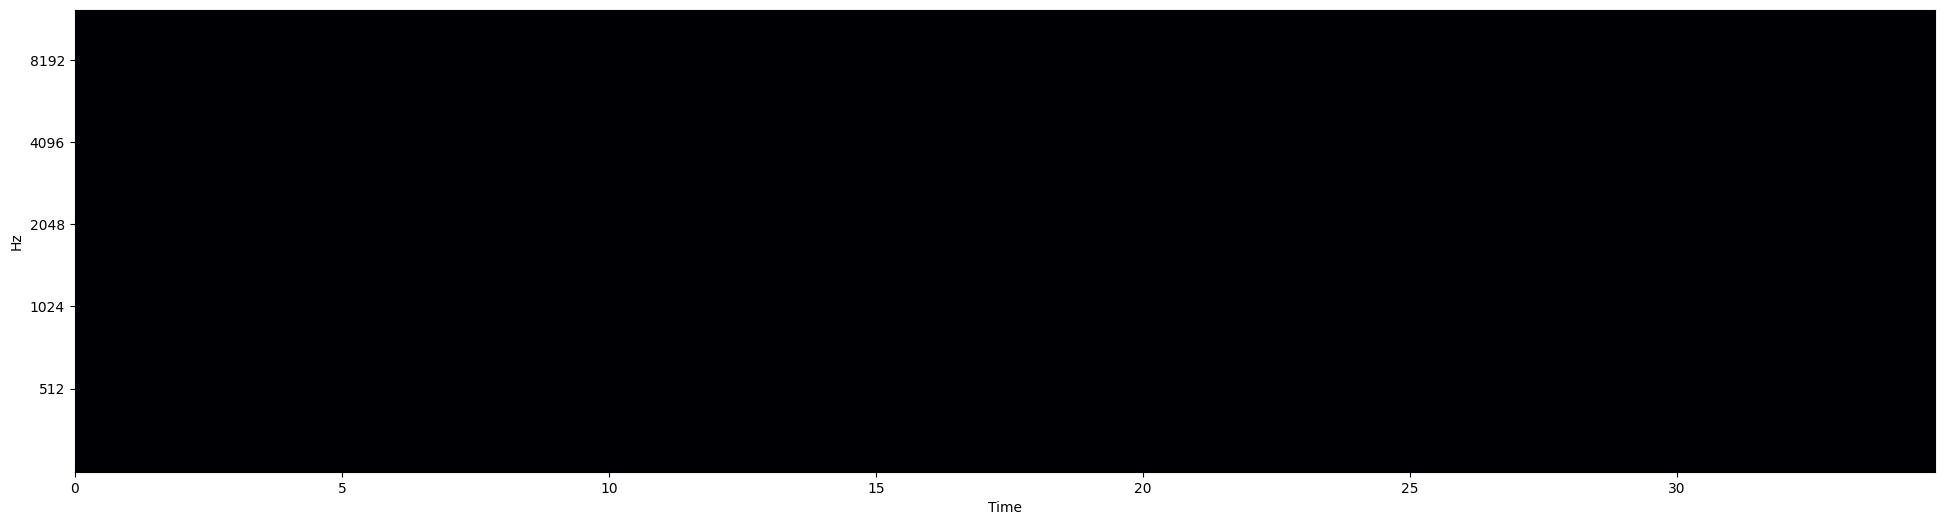

In [25]:
plt.figure(figsize=(24, 6))
librosa.display.specshow(
    np.hstack(frames[:1000]),
    sr=audio_params.sample_rate,
    x_axis='time',
    y_axis='mel',
    fmax=audio_params.fmax,
    fmin=audio_params.fmin,
    hop_length=dataset._hop_length
)

In [23]:
y, sr = librosa.load("../data/synthetic/2022/audio_0.wav", sr=44100)

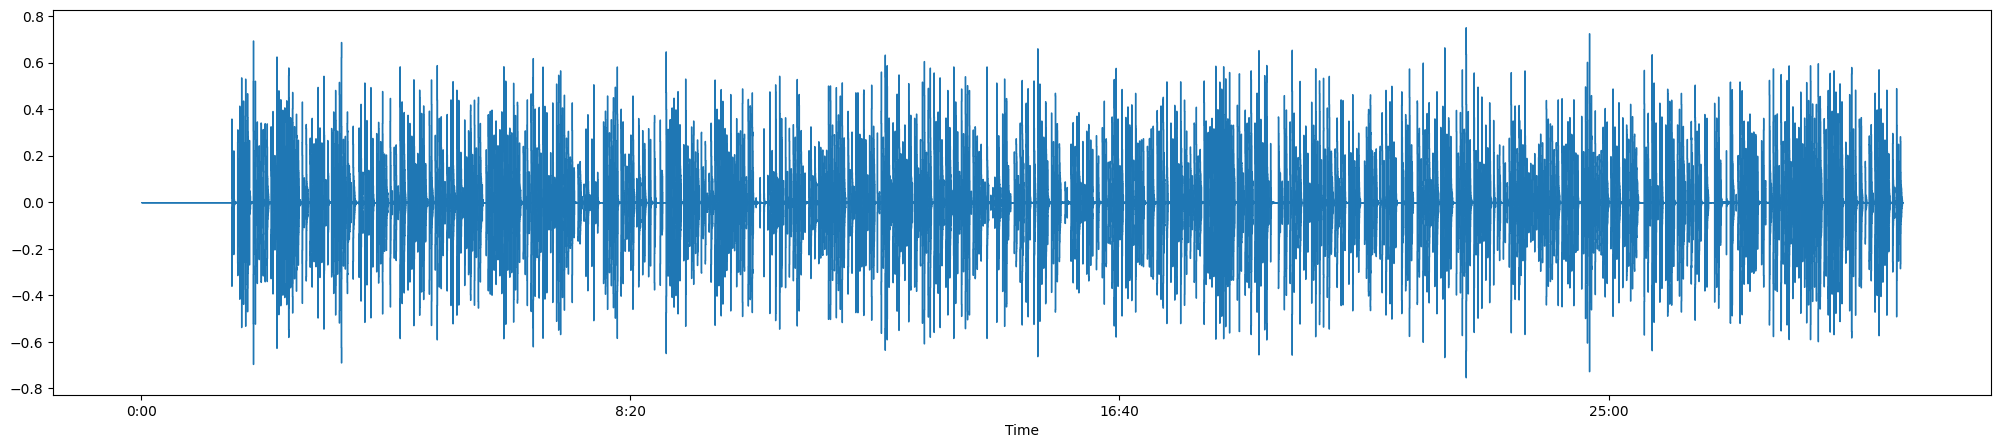

In [26]:
plt.figure(figsize=(25, 5))
librosa.display.waveshow(y, sr=sr)

/tmp/ipykernel_1182/909299195.py:1: FutureWarning: Pass y=[0.         0.         0.         ... 0.00010252 0.00012273 0.0001049 ], sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectrogram = librosa.feature.melspectrogram(y, sr, n_mels=128, fmin=8, fmax=12500, n_fft=1000, hop_length=1000 // 1, window="taylor")


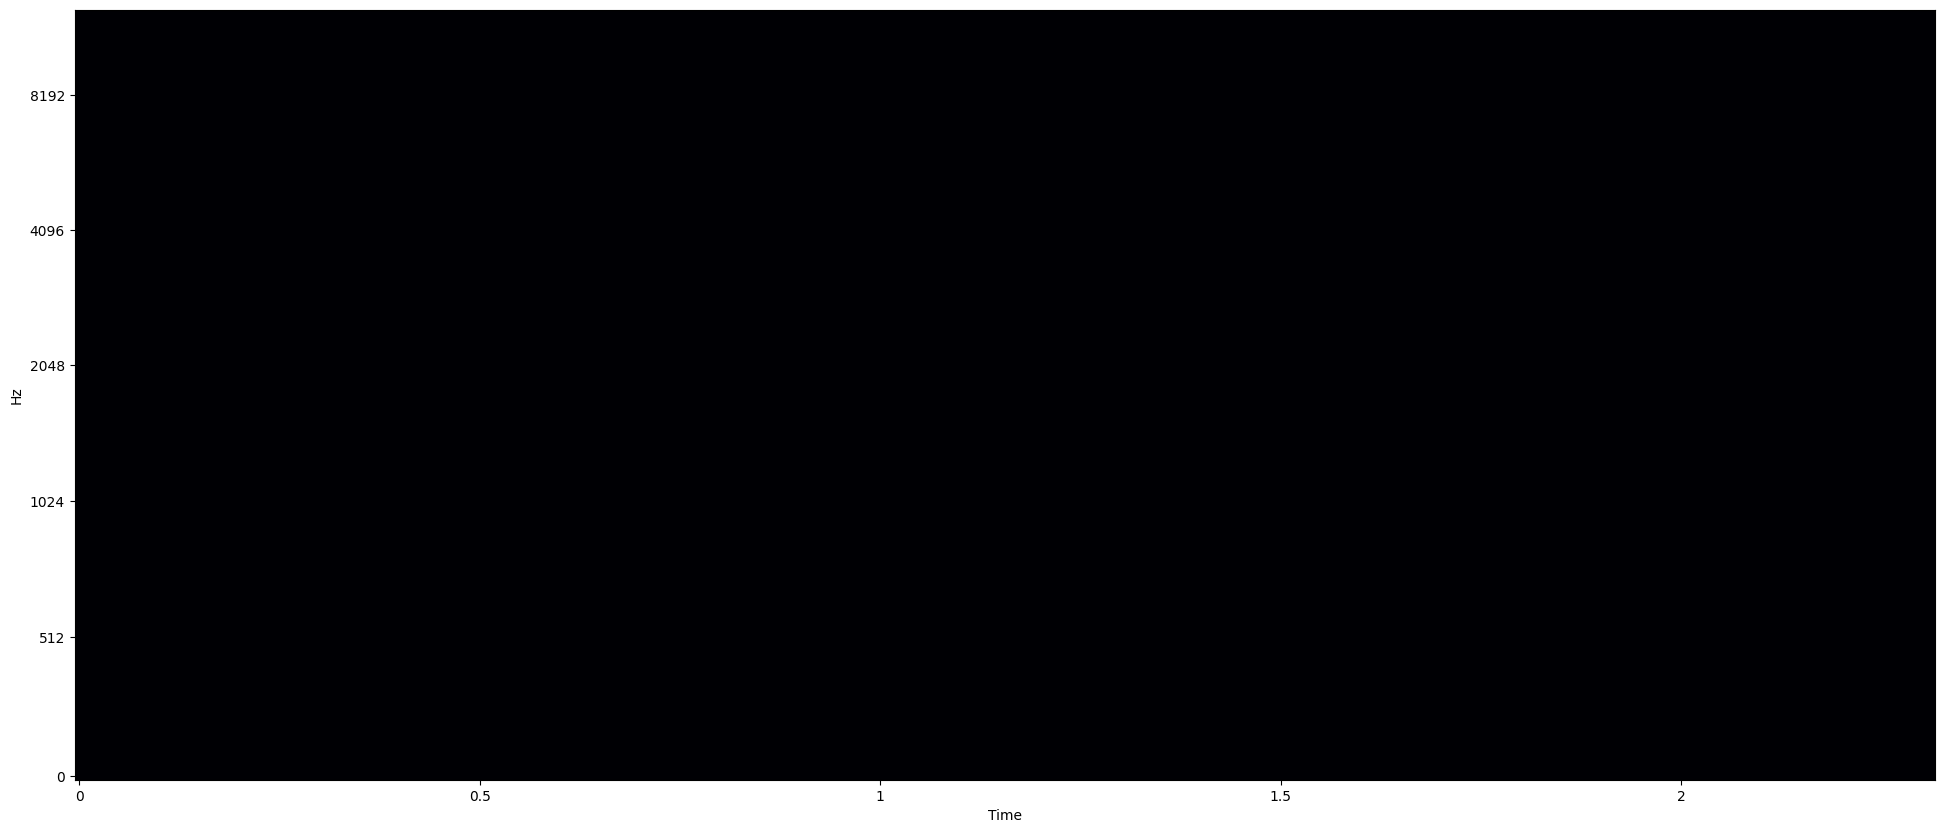

In [24]:
spectrogram = librosa.feature.melspectrogram(y, sr, n_mels=128, fmin=8, fmax=12500, n_fft=1000, hop_length=1000 // 1, window="taylor")
s_db = librosa.power_to_db(spectrogram)

fig, ax = plt.subplots()
fig.set_size_inches(24, 10)
librosa.display.specshow(s_db[:, :200], sr=sr, x_axis='time',y_axis='mel', fmax=12500)